# Steps in this Notebook

1. Imports
2. Snowflake Setup
3. TS Forecasting with DARTS
4. TS Forecasting with AUTOGLUON

# 1.0 Imports

In [53]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.types as T
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col

from snowflake.snowpark.functions import udf
from snowflake.snowpark.types import IntegerType, FloatType, StringType,StructType, StructField

import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.xgboost import XGBClassifier
from snowflake.ml.modeling.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
from snowflake.ml.modeling.impute import SimpleImputer

import json
import pandas as pd
from datetime import date, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [54]:
connection_parameters = json.load(open('/Users/skhara/Documents/GitHub/creds.json'))
session = Session.builder.configs(connection_parameters).create()

# 2.0 Snowflake Setup: Create a Database and Schema

We will be using PUBLIC schema.

In [55]:
session.sql('USE DATABASE TIME_SERIES').collect()
session.sql('USE SCHEMA POC_INVISTA').collect()
session.sql('USE WAREHOUSE ML_WORKLOADS').collect()

[Row(status='Statement executed successfully.')]

In [56]:
# Load TS data from Store_Traffic Database into ACCRUENT_TS_FORECASTING DB for testing purposes.
sdf_raw = session.table('TIME_SERIES.POC_INVISTA.TIME_SERIES_DATA')

In [57]:
# Print the Number of Time Series/Pumps that we have to predict
session.sql('SELECT COUNT(DISTINCT PUMP_ID) FROM TIME_SERIES_DATA').collect()

[Row(COUNT(DISTINCT PUMP_ID)=1000)]

In [58]:
# Print the PUMP_ID and Start and End date of Time Series
session.sql('SELECT PUMP_ID, MIN(TIMESTAMP), MAX(TIMESTAMP) FROM TIME_SERIES_DATA GROUP BY PUMP_ID').collect()

[Row(PUMP_ID=1, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=2, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=3, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=4, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=5, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=6, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=7, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=9, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=10, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(2023, 8, 8)),
 Row(PUMP_ID=11, MIN(TIMESTAMP)=datetime.date(2018, 1, 1), MAX(TIMESTAMP)=datetime.date(20

In [59]:
sdf_raw.limit(5).to_pandas()

,TIMESTAMP,PUMP_ID,VALUE
0,2018-01-01,1,119
1,2018-01-02,1,138
2,2018-01-03,1,134
3,2018-01-04,1,124
4,2018-01-05,1,103


In [60]:
sdf_raw.describe().collect()

[Row(SUMMARY='count', PUMP_ID=2046000.0, VALUE=2046000.0),
 Row(SUMMARY='mean', PUMP_ID=500.5, VALUE=124.109512),
 Row(SUMMARY='stddev', PUMP_ID=288.67506080366553, VALUE=35.57537708865502),
 Row(SUMMARY='min', PUMP_ID=1.0, VALUE=44.0),
 Row(SUMMARY='max', PUMP_ID=1000.0, VALUE=246.0)]

# 2.0 TS Forecasting with Autogluon

### 2.1 Autogluon SF Setup
Loading Autogluon package to Snowflake since its not available through the Anaconda channel.

In [34]:
# !brew install libomp
# !pip install --upgrade pip
# !brew install cmake
# !pip install lightgbm
# !pip install autogluon

Running `brew update --auto-update`...
==> Homebrew collects anonymous analytics.
Read the analytics documentation (and how to opt-out) here:
  https://docs.brew.sh/Analytics
No analytics have been recorded yet (nor will be during this `brew` run).

==> Homebrew is run entirely by unpaid volunteers. Please consider donating:
  https://github.com/Homebrew/brew#donations

==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
aerleon                                  libjcat
apify-cli                                libxmlb
arm-none-eabi-binutils                   lune
arm-none-eabi-gcc                        lxi-tools
arm-none-eabi-gdb                        mariadb@11.0
asn                                      massdriver
asnmap                                   medusa
bazel-diff                               meson-python
bazel-remote                             mgis
cargo-all-features                       mjml
cargo-auditable                      

In [304]:
import autogluon
lib_path = autogluon.__path__[0]
print(lib_path)

/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/autogluon


In [337]:
# Before this step, use a Terminal on your local machine to
# create a ZIP file of the package in the same location
# Step 1: cd /Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages
# Step 2: zip -r autogluon.zip autogluon
zip_file_path = "/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/autogluon.zip"
session.file.put(zip_file_path, "@ML_MODELS", auto_compress=False, overwrite=True)

[PutResult(source='autogluon.zip', target='autogluon.zip', source_size=2540860, target_size=2540864, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

### 2.2 Local Testing

In [61]:
df_input = sdf_raw.filter((F.col("PUMP_ID") == 50)).to_pandas()
df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
df_input = df_input[['TIMESTAMP','VALUE']]
df_input['PUMP'] = 1
df_input

,TIMESTAMP,VALUE,PUMP
0,2018-01-01,114,1
1,2018-01-02,133,1
2,2018-01-03,129,1
3,2018-01-04,120,1
4,2018-01-05,99,1
...,...,...,...
2041,2023-08-04,155,1
2042,2023-08-05,148,1
2043,2023-08-06,152,1
2044,2023-08-07,169,1


In [62]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

RuntimeError: Failed to import transformers.modeling_utils because of the following error (look up to see its traceback):
cannot import name 'DEPRECATED_SERVICE_NAMES' from 'botocore.docs' (/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/botocore/docs/__init__.py)

In [ ]:
start = min(df_input['TIMESTAMP'])
today = max(df_input['TIMESTAMP'])
forecast_horizon = 28

train_data = df_input.loc[(df_input['TIMESTAMP'] >= start) & (df_input['TIMESTAMP'] < today)]
train_data = TimeSeriesDataFrame.from_data_frame(train_data,
                                                 id_column="PUMP",
                                                 timestamp_column="TIMESTAMP")
train_data

#### Training time series models with TimeSeriesPredictor.fit

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=forecast_horizon,
    path="autogluon-test",
    target="VALUE",
    eval_metric="MASE",
)

predictor.fit(
    train_data,
    presets="medium_quality",
    time_limit= 600,
    ag_args_fit={'num_cpus': 16}
)

#### Generating forecasts with TimeSeriesPredictor.predict

In [247]:
predictions = predictor.predict(train_data)
predictions

Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: RecursiveTabular


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
1       2023-08-08  185.352144  184.485821  184.783212  184.997651   
        2023-08-09  193.255079  192.029913  192.450488  192.753751   
        2023-08-10  176.823362  175.322846  175.837942  176.209363   
        2023-08-11  157.779771  156.047125  156.641907  157.070787   
        2023-08-12  148.225740  146.288582  146.953568  147.433070   
        2023-08-13  154.329182  152.207133  152.935589  153.460857   
        2023-08-14  171.736176  169.444101  170.230923  170.798278   
        2023-08-15  188.321452  185.871120  186.712268  187.318796   
        2023-08-16  195.740223  193.141253  194.033426  194.676745   
        2023-08-17  179.512532  176.772978  177.713410  178.391529   
        2023-08-18  160.536768  157.663499  158.649833  159.361050   
        2023-08-19  150.129980  147.128949  148.159142  148.901983   
        2023-08-20  156.379114  153.255542  154.327800  155.100974   
        2023-08-21  173.279141  170.037657  171.150392  171.952752   
        2023-08-22  189.845695  186.490440  187.642230  188.472752   
        2023-08-23  198.963332  195.498040  196.687603  197.545363   
        2023-08-24  180.292071  176.720129  177.946303  178.830461   
        2023-08-25  158.090196  154.414698  155.676421  156.586212   
        2023-08-26  148.330707  144.554492  145.850789  146.785510   
        2023-08-27  154.135381  150.261066  151.591039  152.550043   
        2023-08-28  170.142665  166.172674  167.535490  168.518177   
        2023-08-29  186.755766  182.692350  184.087237  185.093049   
        2023-08-30  195.931479  191.776739  193.202976  194.231393   
        2023-08-31  178.378840  174.134741  175.591653  176.642189   
        2023-09-01  159.313956  154.982340  156.469295  157.541494   
        2023-09-02  147.223839  142.806440  144.322843  145.416275   
        2023-09-03  154.278901  149.777354  151.322643  152.436905   
        2023-09-04  170.439030  165.854879  167.428524  168.563233   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
1       2023-08-08  185.180882  185.352144  185.523405  185.706636   
        2023-08-09  193.012879  193.255079  193.497280  193.756407   
        2023-08-10  176.526728  176.823362  177.119995  177.437361   
        2023-08-11  157.437248  157.779771  158.122294  158.488756   
        2023-08-12  147.842787  148.225740  148.608692  149.018409   
        2023-08-13  153.909679  154.329182  154.748686  155.197508   
        2023-08-14  171.283061  171.736176  172.189292  172.674075   
        2023-08-15  187.837051  188.321452  188.805852  189.324108   
        2023-08-16  195.226438  195.740223  196.254007  196.803700   
        2023-08-17  178.970956  179.512532  180.054108  180.633535   
        2023-08-18  159.968758  160.536768  161.104778  161.712486   
        2023-08-19  149.536713  150.129980  150.723248  151.357978   
        2023-08-20  155.761622  156.379114  156.996606  157.657255   
        2023-08-21  172.638339  173.279141  173.919943  174.605530   
        2023-08-22  189.182402  189.845695  190.508988  191.218638   
        2023-08-23  198.278286  198.963332  199.648378  200.381302   
        2023-08-24  179.585941  180.292071  180.998200  181.753680   
        2023-08-25  157.363595  158.090196  158.816797  159.594180   
        2023-08-26  147.584195  148.330707  149.077218  149.875903   
        2023-08-27  153.369476  154.135381  154.901286  155.720719   
        2023-08-28  169.357846  170.142665  170.927484  171.767153   
        2023-08-29  185.952478  186.755766  187.559054  188.418483   
        2023-08-30  195.110138  195.931479  196.752820  197.631565   
        2023-08-31  177.539834  178.378840  179.217847  180.115491   
        2023-09-01  158.457649  159.313956  160.170264  161.086418   
        2023-09-02  146.350573  147

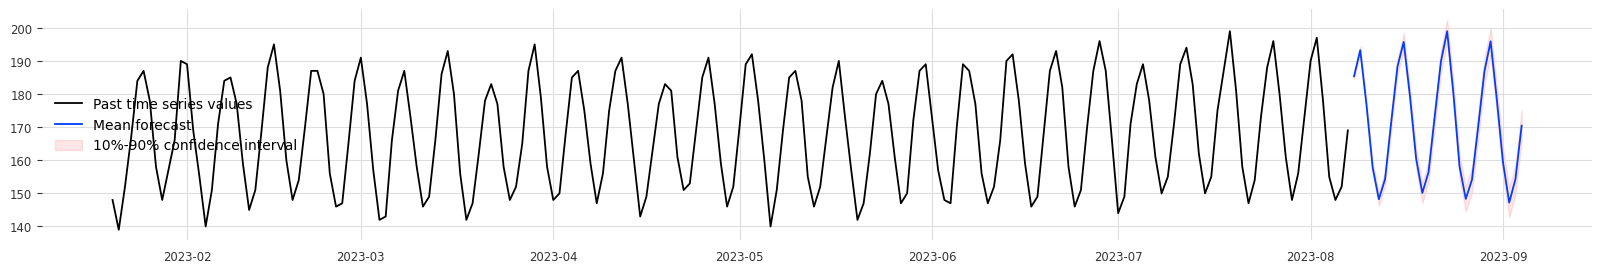

In [251]:
plt.figure(figsize=(20, 3))

pump_id = 1
y_past = train_data.loc[pump_id]["VALUE"]
y_pred = predictions.loc[pump_id]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

In [252]:
df_forecast = pd.DataFrame(predictions.reset_index()[['timestamp','mean']])
df_forecast = df_forecast.rename(columns={'timestamp':'TIMESTAMP','mean':'FORECAST'})
df_forecast

,TIMESTAMP,FORECAST
0,2023-08-08,185.352144
1,2023-08-09,193.255079
2,2023-08-10,176.823362
3,2023-08-11,157.779771
4,2023-08-12,148.225740
5,2023-08-13,154.329182
6,2023-08-14,171.736176
7,2023-08-15,188.321452
8,2023-08-16,195.740223
9,2023-08-17,179.512532


In [362]:
predictor.info()

{'path': '/tmp/',
 'version': '0.8.2',
 'time_fit_training': 22.639357805252075,
 'time_limit': 599.99258685112,
 'best_model': 'RecursiveTabular',
 'best_model_score_val': -0.8299053598818511,
 'num_models_trained': 1,
 'model_info': {'RecursiveTabular': {'name': 'RecursiveTabular',
   'model_type': 'MultiWindowBacktestingModel',
   'eval_metric': 'MASE',
   'fit_time': 4.993220090866089,
   'predict_time': 0.06574010848999023,
   'freq': 'D',
   'prediction_length': 10,
   'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
   'val_score': -0.8299053598818511,
   'hyperparameters': {'max_num_samples': 100000},
   'info_per_val_window': [{'window_index': 0,
     'fit_time': 4.987987995147705,
     'val_score': -0.8299053598818511,
     'predict_time': 0.06574010848999023}]}}}

In [404]:
df_input = sdf_raw.filter((F.col("PUMP_ID") == 1)).to_pandas()
df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
df_input = df_input[['TIMESTAMP','VALUE']]
df_input = df_input.sort_values(by=['TIMESTAMP']).reset_index(drop=True)
df_input['PUMP'] = 1

#Train + Forecast Length
train_length = 600
forecast_horizon = 10
train_end = max(df_input['TIMESTAMP'])
train_start = train_end - pd.Timedelta(days = 600)
df_input = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                        (df_input['TIMESTAMP'] < train_end)].reset_index(drop=True)

In [405]:
df_input

,TIMESTAMP,VALUE,PUMP
0,2021-12-16,168,1
1,2021-12-17,148,1
2,2021-12-18,135,1
3,2021-12-19,136,1
4,2021-12-20,158,1
...,...,...,...
595,2023-08-03,185,1
596,2023-08-04,161,1
597,2023-08-05,153,1
598,2023-08-06,158,1


In [264]:
df_input = sdf_raw.filter((F.col("PUMP_ID") == 1)).to_pandas()
df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
df_input = df_input[['TIMESTAMP','VALUE']]

#do the train & forecast split
train_end = max(df_input['TIMESTAMP'])
train_length = 600
forecast_horizon = 10

train_data = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                          (df_input['TIMESTAMP'] < train_end)]
train_data['PUMP'] = 1

train_data = TimeSeriesDataFrame.from_data_frame(train_data,
                                                 id_column="PUMP",
                                                 timestamp_column="TIMESTAMP")

predictor = TimeSeriesPredictor(prediction_length=forecast_horizon,
                                path="/tmp",
                                target="VALUE",
                                eval_metric="MASE")

predictor.fit(train_data, presets="medium_quality", time_limit= 600)
predictions = predictor.predict(train_data)

df_forecast = pd.DataFrame(predictions.reset_index()[['timestamp','mean']])
df_forecast = df_forecast.rename(columns={'timestamp':'TIMESTAMP','mean':'FORECAST'})
df_forecast['TRAIN_START'] = train_start
df_forecast['TRAIN_END'] = train_end
df_forecast['FORECAST_HORIZON'] = forecast_horizon

================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: fast_training
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MASE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'fast_training',
 'num_val_windows': 1,
 'prediction_length': 10,
 'random_seed': None,
 'target': 'VALUE',
 'time_limit': 600,
 'verbosity': 2}
Provided training data set with 2045 rows, 1 items (item = single time series). Average time series length is 2045.0. Data frequency is 'D'.
AutoGluon will save models to /tmp/
AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'VALUE'

Starting training. Start time is 2023-09-11 21:31:39
Models that will be trained: ['Naive', 'Se

In [265]:
df_forecast

,TIMESTAMP,FORECAST,TRAIN_START,TRAIN_END,FORECAST_HORIZON
0,2023-08-08,192.403393,2018-01-01,2023-08-08,10
1,2023-08-09,202.060077,2018-01-01,2023-08-08,10
2,2023-08-10,185.782121,2018-01-01,2023-08-08,10
3,2023-08-11,163.992034,2018-01-01,2023-08-08,10
4,2023-08-12,153.078651,2018-01-01,2023-08-08,10
5,2023-08-13,160.132807,2018-01-01,2023-08-08,10
6,2023-08-14,176.717942,2018-01-01,2023-08-08,10
7,2023-08-15,193.114971,2018-01-01,2023-08-08,10
8,2023-08-16,202.394075,2018-01-01,2023-08-08,10
9,2023-08-17,188.595510,2018-01-01,2023-08-08,10


### 2.3 Creating UDTF for Distributed Training

In [ ]:
session.s

In [48]:
schema = T.StructType([
    T.StructField("TIMESTAMP", T.DateType()),
    T.StructField("FORECAST", T.IntegerType()),
    T.StructField("TRAIN_START", T.DateType()),
    T.StructField("TRAIN_END", T.DateType()),
    T.StructField("FORECAST_HORIZON", T.IntegerType()),
    T.StructField("MODEL_INFO", T.StringType())
])

@F.udtf(output_schema = schema,
        input_types = [T.VariantType()],
        name = "PUMP_TS_AUTOGLUON",
        is_permanent = True,
        stage_location = "@ML_MODELS",
        session = session,
        packages = ['pandas','gluonts','fsspec==2023.4.0','holidays==0.18',
                  'joblib==1.2.0','lightning-utilities==0.7.1','matplotlib==3.7.1',
                  'plotly==5.9.0','pmdarima==2.0.3','pytorch==2.0.1',
                  'pytorch-lightning==2.0.3','pyyaml==6.0','scikit-learn==1.2.2',
                  'scipy==1.10.1','snowflake-snowpark-python==1.4.0','statsmodels',
                  'tbats==1.1.3','torchmetrics==0.11.4','tqdm','xarray','mlforecast'],
        replace = True,
        imports = ["@ML_MODELS/autogluon.zip"])

class forecast:
    def __init__(self):
        self.rows=[]
        self.dfs=[]
        import os
        def fixed_cpu_count():
            return 4
        os.cpu_count = fixed_cpu_count

    def process(self, data):
        self.rows.append(data)

        # Merge rows into a dataframe
        if len(self.rows) >= 16000:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Merge dataframes into a single dataframe
        # Minimizes memory footprint
        if len(self.dfs) >= 100:
            merged_df = pd.concat(self.dfs)
            self.dfs = [merged_df]

        yield None
    
    def end_partition(self):
        # Merge any remaining rows
        from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
        import pandas as pd
        
        if len(self.rows) > 0:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []

        df_input = pd.concat(self.dfs)
        df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
        df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
        df_input = df_input[['TIMESTAMP','VALUE']]
        df_input = df_input.sort_values(by=['TIMESTAMP']).reset_index(drop=True)
        df_input['PUMP'] = 1

        #Train + Forecast Length
        train_length = 600
        forecast_horizon = 30
        train_end = max(df_input['TIMESTAMP'])
        train_start = train_end - pd.Timedelta(days = 600)
        df_input = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                                (df_input['TIMESTAMP'] < train_end)].reset_index(drop=True)

        
        train = TimeSeriesDataFrame.from_data_frame(df_input,
                                                    id_column="PUMP",
                                                    timestamp_column="TIMESTAMP")

        predictor = TimeSeriesPredictor(prediction_length=forecast_horizon,
                                        path="/tmp",
                                        target="VALUE",
                                        eval_metric="MASE")
        
        predictor.fit(train, presets="medium_quality", time_limit= 1000)
        predictions = predictor.predict(train)
        
        df_forecast = pd.DataFrame(train.reset_index()[['timestamp','VALUE']])
        df_forecast = df_forecast.rename(columns={'timestamp':'TIMESTAMP','VALUE':'FORECAST'})
        df_forecast['TRAIN_START'] = train_start
        df_forecast['TRAIN_END'] = train_end
        df_forecast['FORECAST_HORIZON'] = forecast_horizon
        df_forecast['MODEL_INFO'] = str(predictor.info())
        
#         df_forecast = pd.DataFrame(predictions.reset_index()[['timestamp','mean']])
#         df_forecast = df_forecast.rename(columns={'timestamp':'TIMESTAMP','mean':'FORECAST'})
#         df_forecast['TRAIN_START'] = train_start
#         df_forecast['TRAIN_END'] = train_end
#         df_forecast['FORECAST_HORIZON'] = forecast_horizon
        
        # output prediction
        yield from df_forecast.itertuples(index=False, name=None)

The version of package gluonts in the local environment is 0.13.4, which does not fit the criteria for the requirement gluonts. Your UDF might not work when the package version is different between the server and your local environment
The version of package fsspec in the local environment is 2023.1.0, which does not fit the criteria for the requirement fsspec==2023.4.0. Your UDF might not work when the package version is different between the server and your local environment
The version of package holidays in the local environment is 0.30, which does not fit the criteria for the requirement holidays==0.18. Your UDF might not work when the package version is different between the server and your local environment
The version of package lightning-utilities in the local environment is 0.9.0, which does not fit the criteria for the requirement lightning-utilities==0.7.1. Your UDF might not work when the package version is different between the server and your local environment
The versio

In [49]:
session.sql('SELECT CURRENT_WAREHOUSE(), CURRENT_DATABASE(), CURRENT_SCHEMA()').collect()

[Row(CURRENT_WAREHOUSE()='ML_WORKLOADS', CURRENT_DATABASE()='TIME_SERIES', CURRENT_SCHEMA()='POC_INVISTA')]

In [50]:
# df = session.table('TIME_SERIES_DATA').filter((F.col("PUMP_ID") == 50) | (F.col("PUMP_ID") == 51)) \
#         .with_column('ROW', F.object_construct_keep_null('*')) \
#         .select(F.col('PUMP_ID'), F.col('ROW'))

df = session.table('TIME_SERIES_DATA').filter((F.col("PUMP_ID") == 50)) \
        .with_column('ROW', F.object_construct_keep_null('*')) \
        .select(F.col('PUMP_ID'), F.col('ROW'))

udf_pump_forecasting = F.table_function("PUMP_TS_AUTOGLUON")
variant_column = F.parse_json(df.col('ROW').cast(T.VariantType()))
forecast = df.select(F.col('PUMP_ID'), 
                     udf_pump_forecasting(variant_column).over(partition_by=['PUMP_ID']))

forecast = forecast.with_column('MODEL', F.lit('AutoGluon'))
forecast = forecast.with_column('FORECAST_DATETIME', F.current_timestamp())
forecast.write.save_as_table("FORECAST_USING_AUTOGLUON", mode="overwrite")

KeyboardInterrupt: 

In [ ]:
df_temp = session.table('FORECAST_USING_AUTOGLUON')
df_temp.limit(5).to_pandas()

In [ ]:
df_temp['MODEL_TYPE'][0]

# 3.0 TS Forecasting with DARTS

### 3.1 Upload library to Snowflake Stage
We are uploading to a stage as this library is not available through the Snowflake Anaconda Channel.

In [ ]:
!pip install darts

/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/
zip -r darts.zip darts

In [135]:
import darts
import nfoursid
from darts import TimeSeries
from darts.models import FFT
from darts.metrics import mae, mape

The `Prophet` module could not be imported. To enable Prophet support in Darts, follow the detailed instructions in the installation guide: https://github.com/unit8co/darts/blob/master/INSTALL.md


In [136]:
nfoursid_path = nfoursid.__path__[0]
print(nfoursid_path)

/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/nfoursid


In [137]:
darts_path = darts.__path__[0]
print(darts_path)

/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/darts


In [138]:
zip_file_path = "/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/nfoursid.zip"
session.file.put(zip_file_path, "@ML_MODELS", auto_compress=False, overwrite=True)

[PutResult(source='nfoursid.zip', target='nfoursid.zip', source_size=37773, target_size=37776, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [139]:
zip_file_path = "/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/darts.zip"
session.file.put(zip_file_path, "@ML_MODELS", auto_compress=False, overwrite=True)

[PutResult(source='darts.zip', target='darts.zip', source_size=1773926, target_size=1773936, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

### 3.2 Testing with Dart Locally

In [37]:
from darts.models import NBEATSModel

RuntimeError: Failed to import transformers.modeling_utils because of the following error (look up to see its traceback):
cannot import name 'DEPRECATED_SERVICE_NAMES' from 'botocore.docs' (/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/botocore/docs/__init__.py)

In [420]:
df_input = sdf_raw.filter((F.col("PUMP_ID") == 1)).to_pandas()
df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
df_input = df_input[['TIMESTAMP','VALUE']]
df_input = df_input.sort_values(by=['TIMESTAMP']).reset_index(drop=True)

#Train + Forecast Length
train_length = 600
forecast_horizon = 30
train_end = max(df_input['TIMESTAMP'])
train_start = train_end - pd.Timedelta(days = 600)
df_input = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                        (df_input['TIMESTAMP'] < train_end)].reset_index(drop=True)
df_input = df_input.set_index('TIMESTAMP')
df_input.index.name = 'time'

ts_train = TimeSeries.from_dataframe(df_input, fill_missing_dates=True, freq='D')
ts_train

<TimeSeries (DataArray) (time: 600, component: 1, sample: 1)>
array([[[168.]],

       [[148.]],

       [[135.]],

       [[136.]],

       [[158.]],

       [[180.]],

       [[183.]],

       [[169.]],

       [[147.]],

       [[133.]],

...

       [[154.]],

       [[162.]],

       [[180.]],

       [[198.]],

       [[205.]],

       [[185.]],

       [[161.]],

       [[153.]],

       [[158.]],

       [[176.]]])
Coordinates:
  * time       (time) datetime64[ns] 2021-12-16 2021-12-17 ... 2023-08-07
  * component  (component) object 'VALUE'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [421]:
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    model_name="nbeats_run",
)
model_nbeats.fit(ts_train)

In [427]:
ts_forecast = model_nbeats.predict(30)

Predicting: 0it [00:00, ?it/s]

In [426]:
data = ts_forecast.pd_dataframe().reset_index().values
pd.DataFrame(data, columns = ['DATE','FORECAST'])

,DATE,FORECAST
0,2023-08-08,198.61069
1,2023-08-09,201.967006
2,2023-08-10,188.234551
3,2023-08-11,166.80507
4,2023-08-12,154.226552
5,2023-08-13,160.456274
6,2023-08-14,179.991914
7,2023-08-15,198.759665
8,2023-08-16,202.452268
9,2023-08-17,188.258517


### 3.3 Creating UDTF for multi-node parallelized model training

# Darts with NBeats

In [433]:
schema = T.StructType([
    T.StructField("TIMESTAMP", T.DateType()),
    T.StructField("FORECAST", T.IntegerType()),
    T.StructField("TRAIN_START", T.DateType()),
    T.StructField("TRAIN_END", T.DateType()),
    T.StructField("FORECAST_HORIZON", T.IntegerType())
])

@F.udtf(output_schema = schema,
        input_types = [T.VariantType()],
        name = "PUMP_TS_DARTS", is_permanent=True, stage_location="@ML_MODELS", session=session,
        packages=['pandas', 'fsspec==2023.4.0','holidays==0.18',
                  'joblib==1.2.0','lightning-utilities==0.7.1','matplotlib==3.7.1',
                  'plotly==5.9.0','pmdarima==2.0.3','pytorch==2.0.1',
                  'pytorch-lightning==2.0.3','pyyaml==6.0','scikit-learn==1.2.2',
                  'scipy==1.10.1','snowflake-snowpark-python==1.4.0','statsmodels',
                  'tbats==1.1.3','torchmetrics==0.11.4','tqdm','xarray'
                 ], replace=True,
        imports = ["@ML_MODELS/nfoursid.zip", "@ML_MODELS/darts.zip"])

class forecast:
    def __init__(self):
        self.rows=[]
        self.dfs=[]
        import os
        def fixed_cpu_count():
            return 4
        os.cpu_count = fixed_cpu_count
        return str(os.cpu_count())
    
    def process(self, data):
        self.rows.append(data)

        # Merge rows into a dataframe
        if len(self.rows) >= 16000:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Merge dataframes into a single dataframe
        # Minimizes memory footprint
        if len(self.dfs) >= 100:
            merged_df = pd.concat(self.dfs)
            self.dfs = [merged_df]

        yield None
    
    def end_partition(self):
        # Merge any remaining rows
        from darts import TimeSeries
        from darts.models import NBEATSModel

        if len(self.rows) > 0:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Process Input
        df_input = pd.concat(self.dfs)
        df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
        df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
        df_input = df_input[['TIMESTAMP','VALUE']]

        #Train + Forecast Length
        train_length = 600
        forecast_horizon = 30
        train_end = max(df_input['TIMESTAMP'])
        train_start = train_end - pd.Timedelta(days = 600)
        
        df_input = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                                (df_input['TIMESTAMP'] < train_end)].reset_index(drop=True)
        df_input = df_input.set_index('TIMESTAMP')
        df_input.index.name = 'time'
        
        # Convert DataFrame to Darts TS Object
        ts_train = TimeSeries.from_dataframe(df_input, fill_missing_dates=True, freq='D')
        
        # Initialize Model
        model_nbeats = NBEATSModel(input_chunk_length=30,
                                   output_chunk_length=7,
                                   generic_architecture=True,
                                   num_stacks=10,
                                   num_blocks=1,
                                   num_layers=4,
                                   layer_widths=512,
                                   n_epochs=50,
                                   nr_epochs_val_period=1,
                                   batch_size=800,
                                   model_name="nbeats_run")
        # Fit Model and Predict
        model_nbeats.fit(ts_train)
        ts_forecast = model_nbeats.predict(forecast_horizon)
        
        # Processing
        data = ts_forecast.pd_dataframe().reset_index().values
        df_forecast = pd.DataFrame(data, columns = ['TIMESTAMP','VALUE'])
        df_forecast['TRAIN_START'] = train_start
        df_forecast['TRAIN_END'] = train_end
        df_forecast['FORECAST_HORIZON'] = forecast_horizon

        yield from df_forecast.itertuples(index=False, name=None)

The version of package fsspec in the local environment is 2023.1.0, which does not fit the criteria for the requirement fsspec==2023.4.0. Your UDF might not work when the package version is different between the server and your local environment
The version of package holidays in the local environment is 0.30, which does not fit the criteria for the requirement holidays==0.18. Your UDF might not work when the package version is different between the server and your local environment
The version of package lightning-utilities in the local environment is 0.9.0, which does not fit the criteria for the requirement lightning-utilities==0.7.1. Your UDF might not work when the package version is different between the server and your local environment
The version of package plotly in the local environment is 5.16.0, which does not fit the criteria for the requirement plotly==5.9.0. Your UDF might not work when the package version is different between the server and your local environment
packa

In [ ]:
df = session.table('TIME_SERIES_DATA') \
        .with_column('ROW', F.object_construct_keep_null('*')) \
        .select(F.col('PUMP_ID'), F.col('ROW'))

store_forecast_test = F.table_function("PUMP_TS_DARTS")

variant_column = F.parse_json(df.col('ROW').cast(T.VariantType()))

forecast = df.select(
                F.col('PUMP_ID'), 
                store_forecast_test(variant_column).over(partition_by=['PUMP_ID'])
                )

forecast = forecast.with_column('MODEL', F.lit('NBEATSModel'))
forecast = forecast.with_column('FORECAST_DATETIME', F.current_timestamp())
forecast.write.save_as_table("FORECAST_USING_DARTS_NBEATS", mode="overwrite")
df_temp = session.table('FORECAST_USING_DARTS')
df_temp.limit(5).to_pandas()

# Darts with FFT

In [19]:
schema = T.StructType([
    T.StructField("TIMESTAMP", T.DateType()),
    T.StructField("FORECAST", T.IntegerType()),
    T.StructField("TRAIN_START", T.DateType()),
    T.StructField("TRAIN_END", T.DateType()),
    T.StructField("FORECAST_HORIZON", T.IntegerType())
])

@F.udtf(output_schema = schema,
        input_types = [T.VariantType()],
        name = "PUMP_TS_DARTS_FFT", is_permanent=True, stage_location="@ML_MODELS", session=session,
        packages=['pandas', 'fsspec==2023.4.0','holidays==0.18',
                  'joblib==1.2.0','lightning-utilities==0.7.1','matplotlib==3.7.1',
                  'plotly==5.9.0','pmdarima==2.0.3','pytorch==2.0.1',
                  'pytorch-lightning==2.0.3','pyyaml==6.0','scikit-learn==1.2.2',
                  'scipy==1.10.1','snowflake-snowpark-python==1.4.0','statsmodels',
                  'tbats==1.1.3','torchmetrics==0.11.4','tqdm','xarray'
                 ], replace=True,
        imports = ["@ML_MODELS/nfoursid.zip", "@ML_MODELS/darts.zip"])

class forecast:
    def __init__(self):
        self.rows=[]
        self.dfs=[]
    
    def process(self, data):
        self.rows.append(data)

        # Merge rows into a dataframe
        if len(self.rows) >= 16000:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Merge dataframes into a single dataframe
        # Minimizes memory footprint
        if len(self.dfs) >= 100:
            merged_df = pd.concat(self.dfs)
            self.dfs = [merged_df]

        yield None
    
    def end_partition(self):
        # Merge any remaining rows
        from darts import TimeSeries
        from darts.models import FFT

        if len(self.rows) > 0:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Process Input
        df_input = pd.concat(self.dfs)
        df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
        df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
        df_input = df_input[['TIMESTAMP','VALUE']]

        #Train + Forecast Length
        train_length = 600
        forecast_horizon = 30
        train_end = max(df_input['TIMESTAMP'])
        train_start = train_end - pd.Timedelta(days = 600)
        
        df_input = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                                (df_input['TIMESTAMP'] < train_end)].reset_index(drop=True)
        df_input = df_input.set_index('TIMESTAMP')
        df_input.index.name = 'time'
        
        # Convert DataFrame to Darts TS Object
        ts_train = TimeSeries.from_dataframe(df_input, fill_missing_dates=True, freq='D')
        
        # Initialize Model
        FFT_model = FFT(nr_freqs_to_keep=400,trend=None)
        
        # Fit Model and Predict
        FFT_model.fit(ts_train)
        ts_forecast = FFT_model.predict(forecast_horizon)
        
        # Processing
        data = ts_forecast.pd_dataframe().reset_index().values
        df_forecast = pd.DataFrame(data, columns = ['TIMESTAMP','VALUE'])
        df_forecast['TRAIN_START'] = train_start
        df_forecast['TRAIN_END'] = train_end
        df_forecast['FORECAST_HORIZON'] = forecast_horizon

        yield from df_forecast.itertuples(index=False, name=None)

The version of package fsspec in the local environment is 2023.1.0, which does not fit the criteria for the requirement fsspec==2023.4.0. Your UDF might not work when the package version is different between the server and your local environment
The version of package holidays in the local environment is 0.30, which does not fit the criteria for the requirement holidays==0.18. Your UDF might not work when the package version is different between the server and your local environment
The version of package lightning-utilities in the local environment is 0.9.0, which does not fit the criteria for the requirement lightning-utilities==0.7.1. Your UDF might not work when the package version is different between the server and your local environment
The version of package plotly in the local environment is 5.16.0, which does not fit the criteria for the requirement plotly==5.9.0. Your UDF might not work when the package version is different between the server and your local environment
packa

In [ ]:
# df = session.table('TIME_SERIES_DATA') \
#         .with_column('ROW', F.object_construct_keep_null('*')) \
#         .select(F.col('PUMP_ID'), F.col('ROW'))

# store_forecast_test = F.table_function("PUMP_TS_DARTS_FFT")

# variant_column = F.parse_json(df.col('ROW').cast(T.VariantType()))

# forecast = df.select(
#                 F.col('PUMP_ID'), 
#                 store_forecast_test(variant_column).over(partition_by=['PUMP_ID'])
#                 )

# forecast = forecast.with_column('MODEL', F.lit('FFT'))
# forecast = forecast.with_column('FORECAST_DATETIME', F.current_timestamp())
# forecast.write.save_as_table("FORECAST_USING_DARTS_FFT", mode="overwrite")

In [21]:
df_temp = session.table('FORECAST_USING_DARTS_FFT')
df_temp.limit(5).to_pandas()

,PUMP_ID,TIMESTAMP,FORECAST,TRAIN_START,TRAIN_END,FORECAST_HORIZON,MODEL,FORECAST_DATETIME
0,255,2023-08-08,119,2021-12-16,2023-08-08,30,FFT,2023-09-12 13:54:37.950000-07:00
1,255,2023-08-09,103,2021-12-16,2023-08-08,30,FFT,2023-09-12 13:54:37.950000-07:00
2,255,2023-08-10,95,2021-12-16,2023-08-08,30,FFT,2023-09-12 13:54:37.950000-07:00
3,255,2023-08-11,96,2021-12-16,2023-08-08,30,FFT,2023-09-12 13:54:37.950000-07:00
4,255,2023-08-12,111,2021-12-16,2023-08-08,30,FFT,2023-09-12 13:54:37.950000-07:00


# Darts with RNN

In [31]:
schema = T.StructType([
    T.StructField("TIMESTAMP", T.DateType()),
    T.StructField("FORECAST", T.IntegerType()),
    T.StructField("TRAIN_START", T.DateType()),
    T.StructField("TRAIN_END", T.DateType()),
    T.StructField("FORECAST_HORIZON", T.IntegerType())
])

@F.udtf(output_schema = schema,
        input_types = [T.VariantType()],
        name = "PUMP_TS_DARTS", is_permanent=True, stage_location="@ML_MODELS", session=session,
        packages=['pandas', 'fsspec==2023.4.0','holidays==0.18',
                  'joblib==1.2.0','lightning-utilities==0.7.1','matplotlib==3.7.1',
                  'plotly==5.9.0','pmdarima==2.0.3','pytorch==2.0.1',
                  'pytorch-lightning==2.0.3','pyyaml==6.0','scikit-learn==1.2.2',
                  'scipy==1.10.1','snowflake-snowpark-python==1.4.0','statsmodels',
                  'tbats==1.1.3','torchmetrics==0.11.4','tqdm','xarray'
                 ], replace=True,
        imports = ["@ML_MODELS/nfoursid.zip", "@ML_MODELS/darts.zip"])

class forecast:
    def __init__(self):
        self.rows=[]
        self.dfs=[]

    def process(self, data):
        
        self.rows.append(data)

        # Merge rows into a dataframe
        if len(self.rows) >= 16000:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Merge dataframes into a single dataframe
        # Minimizes memory footprint
        if len(self.dfs) >= 100:
            merged_df = pd.concat(self.dfs)
            self.dfs = [merged_df]

        yield None
    
    def end_partition(self):
        import os
        def fixed_cpu_count():
            return 4
        os.cpu_count = str(fixed_cpu_count)

        from darts import TimeSeries
        from darts.models import XGBModel

        if len(self.rows) > 0:
            df = pd.DataFrame(self.rows)
            self.dfs.append(df)
            self.rows = []
        
        # Process Input
        df_input = pd.concat(self.dfs)
        df_input['TIMESTAMP'] = pd.to_datetime(df_input['TIMESTAMP'])
        df_input.groupby('TIMESTAMP').sum('VALUE').reset_index()
        df_input = df_input[['TIMESTAMP','VALUE']]

        #Train + Forecast Length
        train_length = 600
        forecast_horizon = 30
        train_end = max(df_input['TIMESTAMP'])
        train_start = train_end - pd.Timedelta(days = 600)
        
        df_input = df_input.loc[(df_input['TIMESTAMP'] >= train_start) &
                                (df_input['TIMESTAMP'] < train_end)].reset_index(drop=True)
        df_input = df_input.set_index('TIMESTAMP')
        df_input.index.name = 'time'
        
        # Convert DataFrame to Darts TS Object
        ts_train = TimeSeries.from_dataframe(df_input, fill_missing_dates=True, freq='D')
        
        # Initialize Model
        my_model = RNNModel(
            model="LSTM",
            hidden_dim=20,
            dropout=0,
            batch_size=16,
            n_epochs=300,
            optimizer_kwargs={"lr": 1e-3},
            random_state=42,
            training_length=20,
            input_chunk_length=14,
            force_reset=True,
        )
        # Fit Model and Predict
        my_model.fit(ts_train)
        ts_forecast = my_model.predict(forecast_horizon)
        
        # Processing
        data = ts_forecast.pd_dataframe().reset_index().values
        df_forecast = pd.DataFrame(data, columns = ['TIMESTAMP','VALUE'])
        df_forecast['TRAIN_START'] = train_start
        df_forecast['TRAIN_END'] = train_end
        df_forecast['FORECAST_HORIZON'] = forecast_horizon

        yield from df_forecast.itertuples(index=False, name=None)

The version of package fsspec in the local environment is 2023.1.0, which does not fit the criteria for the requirement fsspec==2023.4.0. Your UDF might not work when the package version is different between the server and your local environment
The version of package holidays in the local environment is 0.30, which does not fit the criteria for the requirement holidays==0.18. Your UDF might not work when the package version is different between the server and your local environment
The version of package lightning-utilities in the local environment is 0.9.0, which does not fit the criteria for the requirement lightning-utilities==0.7.1. Your UDF might not work when the package version is different between the server and your local environment
The version of package plotly in the local environment is 5.16.0, which does not fit the criteria for the requirement plotly==5.9.0. Your UDF might not work when the package version is different between the server and your local environment
packa

In [32]:
df = session.table('TIME_SERIES_DATA') \
        .with_column('ROW', F.object_construct_keep_null('*')) \
        .select(F.col('PUMP_ID'), F.col('ROW'))

store_forecast_test = F.table_function("PUMP_TS_DARTS")

variant_column = F.parse_json(df.col('ROW').cast(T.VariantType()))

forecast = df.select(
                F.col('PUMP_ID'), 
                store_forecast_test(variant_column).over(partition_by=['PUMP_ID'])
                )

forecast = forecast.with_column('MODEL', F.lit('RNN'))
forecast = forecast.with_column('FORECAST_DATETIME', F.current_timestamp())
forecast.write.save_as_table("FORECAST_USING_DARTS_RNN", mode="overwrite")

SnowparkSQLException: (1304): 01aef27c-0001-c100-0021-d9870028a3c2: 100357 (P0000): Python Interpreter Error:
Traceback (most recent call last):
  File "/var/folders/2d/stkxpskx5934bff5mzjj6l340000gn/T/ipykernel_92681/2068412370.py", line 50, in end_partition
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 664, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 627, in _load_backward_compatible
  File "<frozen zipimport>", line 259, in load_module
  File "/home/udf/145383426297/darts.zip/darts/__init__.py", line 11, in <module>
    from .timeseries import TimeSeries, concatenate
  File "<frozen importlib._bootstrap>", line 1007, in _find_and_load
  File "<frozen importlib._bootstrap>", line 986, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 664, in _load_unlocked
  File "<frozen importlib._bootstrap>", line 627, in _load_backward_compatible
  File "<frozen zipimport>", line 259, in load_module
  File "/home/udf/145383426297/darts.zip/darts/timeseries.py", line 51, in <module>
    from scipy.stats import kurtosis, skew
  File "/usr/lib/python_udf/8edf3043ddd07ed9f69ee2ddae822cc6d5f26141e3e97697a7ea83946e7f2bd9/lib/python3.9/site-packages/scipy/stats/__init__.py", line 485, in <module>
    from ._stats_py import *
  File "/usr/lib/python_udf/8edf3043ddd07ed9f69ee2ddae822cc6d5f26141e3e97697a7ea83946e7f2bd9/lib/python3.9/site-packages/scipy/stats/_stats_py.py", line 53, in <module>
    from ._hypotests import _all_partitions
  File "/usr/lib/python_udf/8edf3043ddd07ed9f69ee2ddae822cc6d5f26141e3e97697a7ea83946e7f2bd9/lib/python3.9/site-packages/scipy/stats/_hypotests.py", line 13, in <module>
    from scipy.fft import ifft
  File "/usr/lib/python_udf/8edf3043ddd07ed9f69ee2ddae822cc6d5f26141e3e97697a7ea83946e7f2bd9/lib/python3.9/site-packages/scipy/fft/__init__.py", line 92, in <module>
    from ._helper import next_fast_len
  File "/usr/lib/python_udf/8edf3043ddd07ed9f69ee2ddae822cc6d5f26141e3e97697a7ea83946e7f2bd9/lib/python3.9/site-packages/scipy/fft/_helper.py", line 3, in <module>
    from ._pocketfft import helper as _helper
  File "/usr/lib/python_udf/8edf3043ddd07ed9f69ee2ddae822cc6d5f26141e3e97697a7ea83946e7f2bd9/lib/python3.9/site-packages/scipy/fft/_pocketfft/__init__.py", line 3, in <module>
    from .basic import *
  File "/usr/lib/python_udf/8edf3043ddd07ed9f69ee2ddae822cc6d5f26141e3e97697a7ea83946e7f2bd9/lib/python3.9/site-packages/scipy/fft/_pocketfft/basic.py", line 7, in <module>
    from .helper import (_asfarray, _init_nd_shape_and_axes, _datacopied,
  File "/usr/lib/python_udf/8edf3043ddd07ed9f69ee2ddae822cc6d5f26141e3e97697a7ea83946e7f2bd9/lib/python3.9/site-packages/scipy/fft/_pocketfft/helper.py", line 12, in <module>
    _cpu_count = os.cpu_count()
TypeError: 'str' object is not callable
 in function PUMP_TS_DARTS with handler compute

In [36]:
from darts.models import FFT

RuntimeError: Failed to import transformers.modeling_utils because of the following error (look up to see its traceback):
cannot import name 'DEPRECATED_SERVICE_NAMES' from 'botocore.docs' (/Users/skhara/anaconda3/envs/pysnowpark_ml_tpcds/lib/python3.9/site-packages/botocore/docs/__init__.py)